In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH='Dataset.csv'
column_names=["x_axis","y_axis","x_vector","y_vector"]
def load_dataset(path):
    rows = []
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if i==0 or not line.strip() or line.lstrip().startswith("#"):
                continue
            parts=line.strip().split(",")
            if len(parts)!=4:
                continue
            try:
                row=[float(p) for p in parts]
            except ValueError:
                continue
            rows.append(row)
    data=np.array(rows,dtype=float)
    if data.size>0:
        mask=~np.isnan(data).any(axis=1)
        data=data[mask]
    return data

data=load_dataset(DATASET_PATH)
print("Loaded shape:",data.shape)
print(data)

Loaded shape: (733582, 4)
[[ 2.64240535e+02  3.82300000e+02  1.21834596e-04  6.97989934e-03]
 [ 2.64233555e+02  3.82299878e+02 -9.93909755e-02 -1.90688059e-02]
 [ 2.64252624e+02  3.82399269e+02 -1.98295355e-01  4.18368867e-02]
 ...
 [ 1.77119857e+01  8.21448060e+01  6.84552266e+00 -2.25133134e-02]
 [ 1.77344990e+01  7.52992834e+01  6.94552266e+00  1.74866866e-02]
 [ 1.77170123e+01  6.83537607e+01  7.04552266e+00 -2.25133134e-02]]


In [ ]:
col_min=data.min(axis=0)
col_max=data.max(axis=0)
print("Min per column:", col_min)
print("Max per column:", col_max)

Min per column: [-611.63329692   65.90435852   -7.74865952   -7.99525405]
Max per column: [610.36674833 901.98221322   8.           7.37486622]


In [ ]:
denom=col_max-col_min
denom[denom==0.0]=1.0
normalized=(data-col_min)/denom
mask=np.isfinite(normalized).all(axis=1)
normalized=normalized[mask]

display("Normalised shape:", normalized.shape)
np.savetxt(
    "Normalize.csv",
    normalized,
    delimiter=",",
    header=",".join(column_names),
    comments="",
)

'Normalised shape:'

(733582, 4)

In [5]:
print(normalized)

[[0.71675434 0.37842844 0.49202799 0.52063574]
 [0.71674862 0.3784283  0.48570918 0.51894098]
 [0.71676423 0.37854718 0.47942901 0.52290358]
 ...
 [0.51501249 0.01942456 0.92669361 0.51871687]
 [0.51503091 0.0112369  0.93304336 0.52131933]
 [0.5150166  0.00292963 0.93939311 0.51871687]]


In [ ]:
X=normalized[:, :2]
Y=normalized[:, 2:4]

n_samples=X.shape[0]
indices=np.arange(n_samples)
np.random.shuffle(indices)

X=X[indices]
Y=Y[indices]

n_train=int(0.70*n_samples)
n_val=int(0.15*n_samples)
n_test=n_samples-n_train-n_val

X_train=X[:n_train]
Y_train=Y[:n_train]

X_val=X[n_train:n_train+n_val]
Y_val=Y[n_train:n_train+n_val]

X_test=X[n_train+n_val:]
Y_test=Y[n_train+n_val:]

print("Train:",X_train.shape,Y_train.shape)
print("Val:  ",X_val.shape,Y_val.shape)
print("Test: ",X_test.shape,Y_test.shape)

test_data=np.hstack([X_test,Y_test])

header="x_axis,y_axis,x_vector,y_vector"

with open("NormaliseDataforTest.csv", "w") as f:
    f.write(header + "\n")
    for row in test_data:
        f.write(",".join(f"{v:.10f}" for v in row) + "\n")

print("\nSaved test set as NormaliseDataforTest.csv")

Train: (513507, 2) (513507, 2)
Val:   (110037, 2) (110037, 2)
Test:  (110038, 2) (110038, 2)

Saved test set as NormaliseDataforTest.csv


In [ ]:
input_size=2
hidden_size=4   
output_size=2   
#FEED FORWARD NEURAL NETWORK
weights_input_hidden=np.random.uniform(-0.5, 0.5, (hidden_size, input_size))
weights_hidden_output=np.random.uniform(-0.5, 0.5, (output_size, hidden_size))

learning_rate=0.3

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_deriv(y):
    return y*(1.0-y)

def forward_pass(x_row):
    z_hidden=weights_input_hidden @ x_row          
    a_hidden=sigmoid(z_hidden)                    
    z_out=weights_hidden_output @ a_hidden       
    y_hat=z_out

    return a_hidden,y_hat

def rmse(X_batch,Y_batch):
    preds = []
    for x_row in X_batch:
        _, y_hat=forward_pass(x_row)
        preds.append(y_hat)
    preds=np.vstack(preds)
    diff=preds-Y_batch
    return np.sqrt(np.mean(diff**2))

In [ ]:
max_epochs=100
batch_size=32
rmse_values_train=[]
rmse_values_val=[]

best_val_rmse=float("inf")
best_w_in_hid=None
best_w_hid_out=None
patience=30
patience_counter=0

for epoch in range(max_epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train_sh=X_train[perm]
    Y_train_sh=Y_train[perm]
    for start in range(0, X_train_sh.shape[0], batch_size):
        end=start+batch_size
        X_batch=X_train_sh[start:end]
        Y_batch=Y_train_sh[start:end]
        grad_w_in_hid=np.zeros_like(weights_input_hidden)
        grad_w_hid_out=np.zeros_like(weights_hidden_output)
#BACKPROPAGATION USING GRADIENT DESCENT
        for x_row, y_true in zip(X_batch, Y_batch):
            a_hidden,y_hat=forward_pass(x_row)
            error_out=y_hat-y_true
            grad_w_hid_out+=np.outer(error_out, a_hidden)
            delta_hidden=(weights_hidden_output.T @ error_out) * sigmoid_deriv(a_hidden)
            grad_w_in_hid+=np.outer(delta_hidden, x_row)
        if len(X_batch) > 0:
            grad_w_in_hid/=len(X_batch)
            grad_w_hid_out/=len(X_batch)
#GRADIENT DESCENT ALGO
        weights_input_hidden-=learning_rate*grad_w_in_hid
        weights_hidden_output-=learning_rate*grad_w_hid_out

    train_rmse=rmse(X_train,Y_train)
    val_rmse=rmse(X_val,Y_val)
    rmse_values_train.append(train_rmse)
    rmse_values_val.append(val_rmse)
    print(f"Epoch {epoch:3d} - train RMSE={train_rmse:.6f}, val RMSE={val_rmse:.6f}")

    if val_rmse<best_val_rmse:
        best_val_rmse=val_rmse
        patience_counter=0
        best_w_in_hid=weights_input_hidden.copy()
        best_w_hid_out=weights_hidden_output.copy()
    else:
        patience_counter+=1
        if patience_counter>=patience:
            print("Early stopping triggered at epoch", epoch)
            break

if best_w_in_hid is not None:
    weights_input_hidden=best_w_in_hid
    weights_hidden_output=best_w_hid_out
print("\nBest validation RMSE:", best_val_rmse)

Epoch   0 - train RMSE=0.127647, val RMSE=0.127350
Epoch   1 - train RMSE=0.124269, val RMSE=0.124034
Epoch   2 - train RMSE=0.120761, val RMSE=0.120490
Epoch   3 - train RMSE=0.119743, val RMSE=0.119460
Epoch   4 - train RMSE=0.117012, val RMSE=0.116728
Epoch   5 - train RMSE=0.125681, val RMSE=0.125367
Epoch   6 - train RMSE=0.126206, val RMSE=0.125933
Epoch   7 - train RMSE=0.116707, val RMSE=0.116419
Epoch   8 - train RMSE=0.119567, val RMSE=0.119317
Epoch   9 - train RMSE=0.117165, val RMSE=0.116900
Epoch  10 - train RMSE=0.118603, val RMSE=0.118357
Epoch  11 - train RMSE=0.119331, val RMSE=0.119063
Epoch  12 - train RMSE=0.116224, val RMSE=0.115943
Epoch  13 - train RMSE=0.119471, val RMSE=0.119232
Epoch  14 - train RMSE=0.118768, val RMSE=0.118473
Epoch  15 - train RMSE=0.116773, val RMSE=0.116484
Epoch  16 - train RMSE=0.118221, val RMSE=0.117936
Epoch  17 - train RMSE=0.118478, val RMSE=0.118221
Epoch  18 - train RMSE=0.135249, val RMSE=0.134919
Epoch  19 - train RMSE=0.118873

In [14]:
print("Final input->hidden weights:")
print(weights_input_hidden)

Final input->hidden weights:
[[ 2.10050914 -5.50494811]
 [ 3.71669002 -1.580667  ]
 [ 2.14915179 -1.56640093]
 [-1.02762595 -0.46879742]]


In [15]:
print("Final hidden->output weights:")
print(weights_hidden_output)

Final hidden->output weights:
[[ 1.31500456  3.32735183 -4.55340553  1.39037922]
 [-0.38735794 -0.26112676  1.48243235 -0.26744983]]


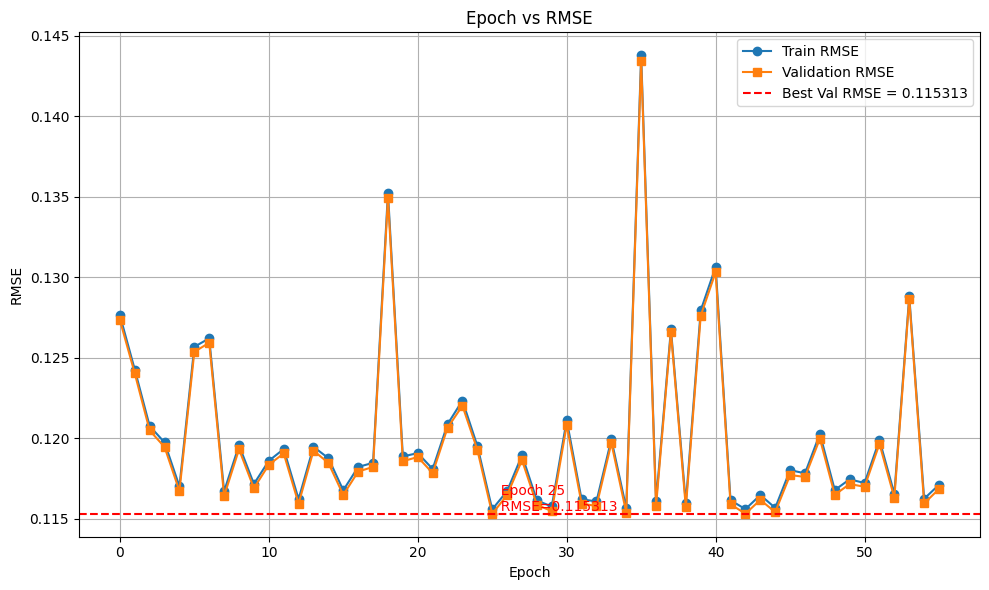

In [ ]:
import matplotlib.pyplot as plt
epochs=range(len(rmse_values_train))
best_epoch=rmse_values_val.index(best_val_rmse)

plt.figure(figsize=(10, 6))
plt.plot(epochs, rmse_values_train, label="Train RMSE", marker='o')
plt.plot(epochs, rmse_values_val,   label="Validation RMSE", marker='s')

plt.axhline(best_val_rmse, color='red', linestyle='--', label=f"Best Val RMSE = {best_val_rmse:.6f}")
plt.scatter(best_epoch, best_val_rmse, color='red')
plt.text(best_epoch, best_val_rmse,
         f"  Epoch {best_epoch}\n  RMSE={best_val_rmse:.6f}",
         color='red', fontsize=10, verticalalignment='bottom')

plt.title("Epoch vs RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()